# 1. Thư viện cần thiết

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [12]:
df = pd.read_csv('ETH_Dataset.csv')
df['ClosingPrice'] = df['Closing Price (USD)']/10000
df.pop('Currency')
df.pop('24h Open (USD)')
df.pop('24h High (USD)')
df.pop('24h Low (USD)')
df.pop('Closing Price (USD)')
df

,Date,ClosingPrice
0,2020-06-01,0.023125
1,2020-06-02,0.025006
2,2020-06-03,0.023731
3,2020-06-04,0.024452
4,2020-06-05,0.024341
...,...,...
381,2021-06-17,0.238713
382,2021-06-18,0.234291
383,2021-06-19,0.220833
384,2021-06-20,0.218141


In [13]:
#Lấy Date làm index

In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)

### Vẽ sơ đồ minh họa

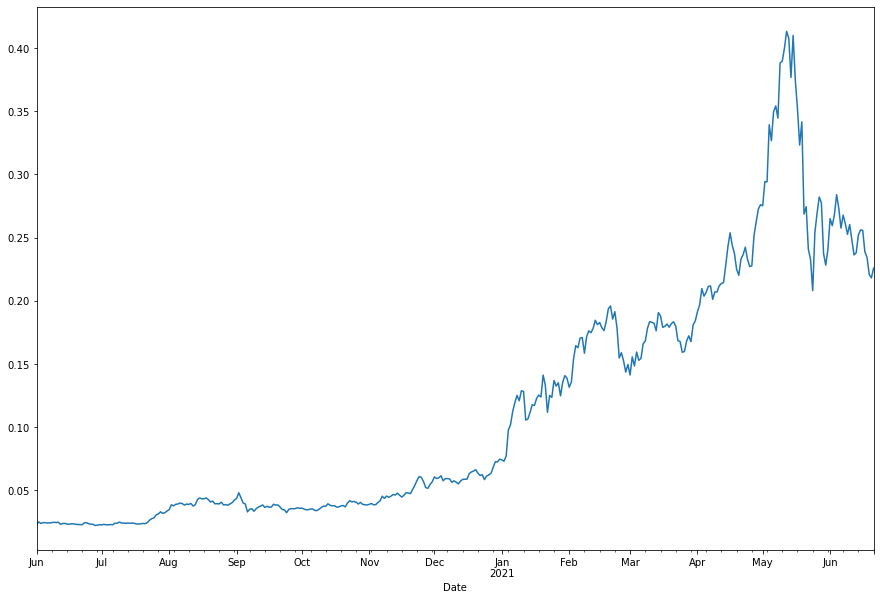

In [15]:
df['ClosingPrice'].plot(kind='line',figsize=(15, 10))

plt.show()

# 2. Tiền xử lý và Chia train/test

#### 2.1 Chi dữ liệu train test theo tỉ lệ train: 80%, test: 20%

In [16]:
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size

In [17]:
price =df[['ClosingPrice']]
price

,ClosingPrice
Date,
2020-06-01,0.023125
2020-06-02,0.025006
2020-06-03,0.023731
2020-06-04,0.024452
2020-06-05,0.024341
...,...
2021-06-17,0.238713
2021-06-18,0.234291
2021-06-19,0.220833


In [18]:
price = np.array(price)
price

array([[0.02312504],
       [0.02500599],
       [0.02373091],
       [0.02445194],
       [0.02434133],
       [0.02407664],
       [0.02423214],
       [0.02438257],
       [0.02470408],
       [0.02445429],
       [0.02474454],
       [0.02305056],
       [0.02372197],
       [0.02382201],
       [0.02326133],
       [0.0231255 ],
       [0.02347509],
       [0.0234031 ],
       [0.02318059],
       [0.02288903],
       [0.02287452],
       [0.02276155],
       [0.02432282],
       [0.02429271],
       [0.02351757],
       [0.02325691],
       [0.02299451],
       [0.02214079],
       [0.02241848],
       [0.02283333],
       [0.02259468],
       [0.02307049],
       [0.0226723 ],
       [0.02263593],
       [0.02288072],
       [0.02270958],
       [0.02389297],
       [0.0238434 ],
       [0.02482819],
       [0.02417872],
       [0.02401468],
       [0.02389943],
       [0.02402237],
       [0.02393273],
       [0.02408414],
       [0.02384254],
       [0.02330853],
       [0.023

In [19]:
train, test = price[0:train_size,:], price[train_size:len(df),:]
print(len(train), len(test))

308 78


# 3. Thực hiện mô hình ARIMA

In [20]:
import pmdarima as pmd

def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              trace=True)
    return autoarima_model

In [21]:
arima_model = arimamodel(train)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2385.344, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2388.668, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2387.345, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2387.338, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2386.301, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.574 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  308
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1196.334
Date:                Tue, 22 Jun 2021   AIC                          -2388.668
Time:                        10:57:43   BIC                          -2381.215
Sample:                             0   HQIC                         -2385.688
                                - 308                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.000      2.088      0.037    3.61e-05       0.001
sigma2      2.414e-05   9.58e-07     25.201      0.000    2.23e-05     2.6e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):               518.75
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):              29.09   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
ARIMA_predict = arima_model.predict(len(test))

# 4. Quá trình kết hợp SVR

In [23]:
prediction = pd.DataFrame(arima_model.predict(len(test)),index=df.tail(len(test)).index)
prediction.columns=['ARIMA_predict']

In [24]:
prediction['ClosingPrice']=df['ClosingPrice'].tail(len(test))

In [25]:
prediction

,ARIMA_predict,ClosingPrice
Date,,
2021-04-05,0.204263,0.206751
2021-04-06,0.204851,0.211414
2021-04-07,0.205439,0.211760
2021-04-08,0.206027,0.201155
2021-04-09,0.206615,0.206966
...,...,...
2021-06-17,0.247188,0.238713
2021-06-18,0.247776,0.234291
2021-06-19,0.248364,0.220833


In [26]:
prediction['Error'] = prediction['ClosingPrice'] -prediction['ARIMA_predict']

prediction

,ARIMA_predict,ClosingPrice,Error
Date,,,
2021-04-05,0.204263,0.206751,0.002488
2021-04-06,0.204851,0.211414,0.006563
2021-04-07,0.205439,0.211760,0.006320
2021-04-08,0.206027,0.201155,-0.004872
2021-04-09,0.206615,0.206966,0.000351
...,...,...,...
2021-06-17,0.247188,0.238713,-0.008475
2021-06-18,0.247776,0.234291,-0.013485
2021-06-19,0.248364,0.220833,-0.027531


In [27]:
prediction['Date']=prediction.index
prediction

,ARIMA_predict,ClosingPrice,Error,Date
Date,,,,
2021-04-05,0.204263,0.206751,0.002488,2021-04-05
2021-04-06,0.204851,0.211414,0.006563,2021-04-06
2021-04-07,0.205439,0.211760,0.006320,2021-04-07
2021-04-08,0.206027,0.201155,-0.004872,2021-04-08
2021-04-09,0.206615,0.206966,0.000351,2021-04-09
...,...,...,...,...
2021-06-17,0.247188,0.238713,-0.008475,2021-06-17
2021-06-18,0.247776,0.234291,-0.013485,2021-06-18
2021-06-19,0.248364,0.220833,-0.027531,2021-06-19


In [28]:
prediction["timestamp"] = pd.to_datetime(prediction.Date).astype(np.int64)
prediction

,ARIMA_predict,ClosingPrice,Error,Date,timestamp
Date,,,,,
2021-04-05,0.204263,0.206751,0.002488,2021-04-05,1617580800000000000
2021-04-06,0.204851,0.211414,0.006563,2021-04-06,1617667200000000000
2021-04-07,0.205439,0.211760,0.006320,2021-04-07,1617753600000000000
2021-04-08,0.206027,0.201155,-0.004872,2021-04-08,1617840000000000000
2021-04-09,0.206615,0.206966,0.000351,2021-04-09,1617926400000000000
...,...,...,...,...,...
2021-06-17,0.247188,0.238713,-0.008475,2021-06-17,1623888000000000000
2021-06-18,0.247776,0.234291,-0.013485,2021-06-18,1623974400000000000
2021-06-19,0.248364,0.220833,-0.027531,2021-06-19,1624060800000000000


In [29]:
prediction.pop('Date')
prediction

,ARIMA_predict,ClosingPrice,Error,timestamp
Date,,,,
2021-04-05,0.204263,0.206751,0.002488,1617580800000000000
2021-04-06,0.204851,0.211414,0.006563,1617667200000000000
2021-04-07,0.205439,0.211760,0.006320,1617753600000000000
2021-04-08,0.206027,0.201155,-0.004872,1617840000000000000
2021-04-09,0.206615,0.206966,0.000351,1617926400000000000
...,...,...,...,...
2021-06-17,0.247188,0.238713,-0.008475,1623888000000000000
2021-06-18,0.247776,0.234291,-0.013485,1623974400000000000
2021-06-19,0.248364,0.220833,-0.027531,1624060800000000000


In [30]:
svr_df = prediction.copy()
svr_df.pop('ClosingPrice')
svr_df.pop('ARIMA_predict')
svr_df

,Error,timestamp
Date,,
2021-04-05,0.002488,1617580800000000000
2021-04-06,0.006563,1617667200000000000
2021-04-07,0.006320,1617753600000000000
2021-04-08,-0.004872,1617840000000000000
2021-04-09,0.000351,1617926400000000000
...,...,...
2021-06-17,-0.008475,1623888000000000000
2021-06-18,-0.013485,1623974400000000000
2021-06-19,-0.027531,1624060800000000000


In [31]:
svr_df.reset_index(drop=True, inplace=True)
svr_df

,Error,timestamp
0,0.002488,1617580800000000000
1,0.006563,1617667200000000000
2,0.006320,1617753600000000000
3,-0.004872,1617840000000000000
4,0.000351,1617926400000000000
...,...,...
73,-0.008475,1623888000000000000
74,-0.013485,1623974400000000000
75,-0.027531,1624060800000000000
76,-0.030811,1624147200000000000


In [32]:
svr_df = svr_df.values
X = svr_df[:,1].reshape(-1,1)
Y = svr_df[:,0:1]

In [33]:
#RBF
from sklearn.svm import SVR
rbf_svr = SVR(kernel='rbf')
rbf_svr.fit(X,Y)

c:\users\minh nhut\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [34]:
predict = rbf_svr.predict(X)

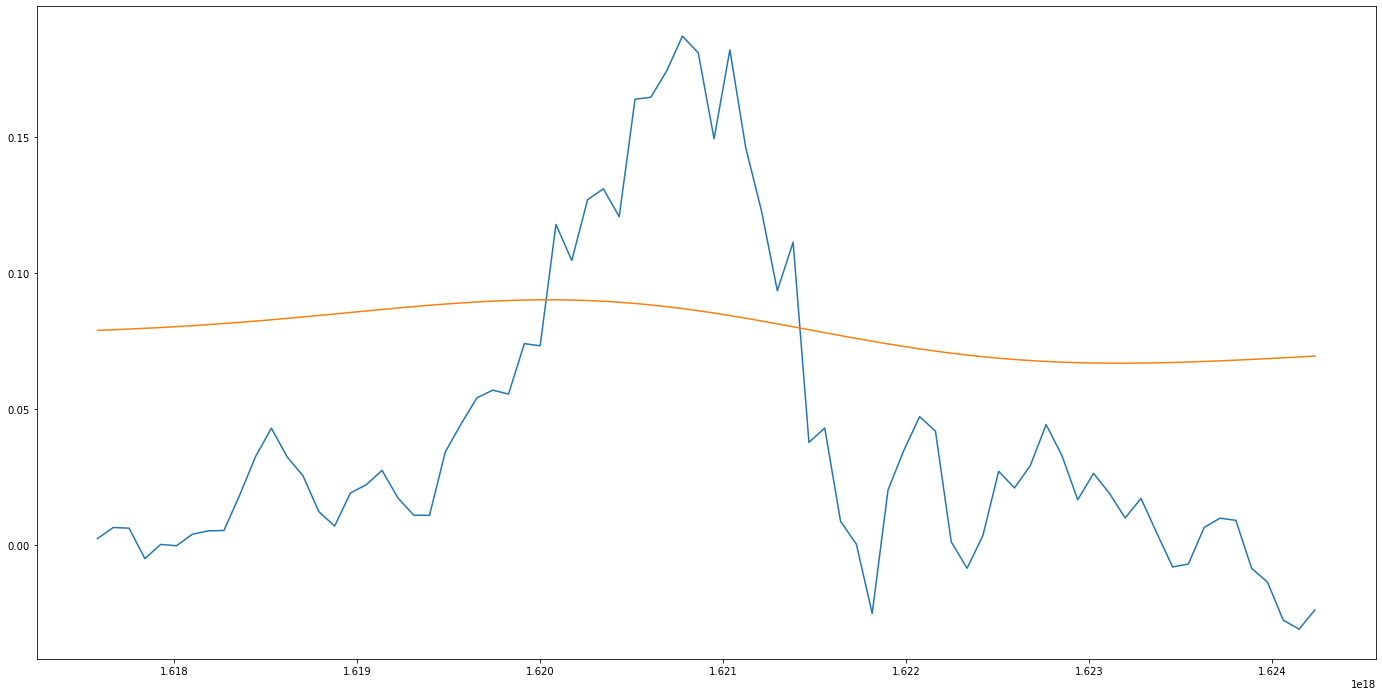

In [35]:
fig= plt.figure(figsize=(24,12))
plt.plot(X,Y)
plt.plot(X,predict)
plt.show()

In [36]:
prediction['Error_pred'] = predict
prediction

,ARIMA_predict,ClosingPrice,Error,timestamp,Error_pred
Date,,,,,
2021-04-05,0.204263,0.206751,0.002488,1617580800000000000,0.079069
2021-04-06,0.204851,0.211414,0.006563,1617667200000000000,0.079290
2021-04-07,0.205439,0.211760,0.006320,1617753600000000000,0.079536
2021-04-08,0.206027,0.201155,-0.004872,1617840000000000000,0.079808
2021-04-09,0.206615,0.206966,0.000351,1617926400000000000,0.080106
...,...,...,...,...,...
2021-06-17,0.247188,0.238713,-0.008475,1623888000000000000,0.068377
2021-06-18,0.247776,0.234291,-0.013485,1623974400000000000,0.068667
2021-06-19,0.248364,0.220833,-0.027531,1624060800000000000,0.068970


In [37]:
prediction['ARIMA_SVR']=prediction['ARIMA_predict']+prediction['Error_pred']
prediction

,ARIMA_predict,ClosingPrice,Error,timestamp,Error_pred,ARIMA_SVR
Date,,,,,,
2021-04-05,0.204263,0.206751,0.002488,1617580800000000000,0.079069,0.283332
2021-04-06,0.204851,0.211414,0.006563,1617667200000000000,0.079290,0.284141
2021-04-07,0.205439,0.211760,0.006320,1617753600000000000,0.079536,0.284975
2021-04-08,0.206027,0.201155,-0.004872,1617840000000000000,0.079808,0.285835
2021-04-09,0.206615,0.206966,0.000351,1617926400000000000,0.080106,0.286721
...,...,...,...,...,...,...
2021-06-17,0.247188,0.238713,-0.008475,1623888000000000000,0.068377,0.315565
2021-06-18,0.247776,0.234291,-0.013485,1623974400000000000,0.068667,0.316443
2021-06-19,0.248364,0.220833,-0.027531,1624060800000000000,0.068970,0.317334


# 4. Đánh giá mô hình ARIMA

In [38]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [39]:
#MAPE
mean_absolute_percentage_error(prediction.ClosingPrice,prediction.ARIMA_SVR)

23.22413262298702

In [40]:
#RMSE
import math
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(prediction.ClosingPrice,prediction.ARIMA_SVR)
RMSE = math.sqrt(MSE)
print(RMSE)

0.06310770435132008
